# ARFIMA


In [1]:
# For data manipulation
import pandas as pd
import numpy as np

# For time series analysis
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

# For data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('seaborn-darkgrid')

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Import arfima package
from arfima import arfima, __frac_diff


In [2]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh', title = 'Time Series Analysis Plots' ):
    '''Esta función muestra el gráfico de la serie y de las funciones ACF y PACF.'''
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_ylabel(r'$y_t$')
        ts_ax.set_xlabel(r'$t$')
        ts_ax.set_title(title)
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        
        plt.tight_layout()
    return

## Importación de datos
Seleccionamos una serie de datos diarios de precios de acciones de APPLE.

In [3]:
#import yfinance as yf
#data = yf.download('AAPL', start='2001-01-01', end='2023-09-15',
#                   auto_adjust=True, threads=True)


En caso de utilizar 'AAPL.csv' considerar la columna 'Adj Close'.

In [4]:
data = pd.read_csv('AAPL.csv', index_col = 'Date', parse_dates=True)



Graficamos la serie:

<Axes: xlabel='Date'>

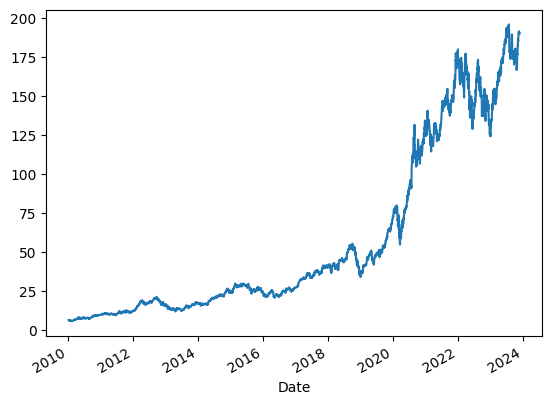

In [5]:
data['Adj Close'].plot()

Graficamos la serie diferenciada:

<Axes: xlabel='Date'>

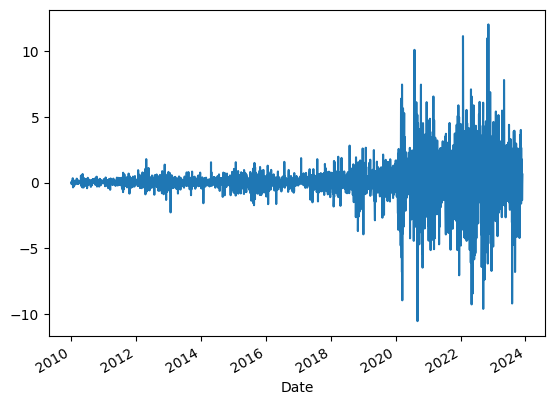

In [6]:
data['Close'].diff().plot()


Un posible inconveniente es que una diferenciación de orden 1 sea más que suficiente para lograr la estacionariedad. Los modelos ARFIMA(p,d,q) consideran la posibilidad de diferenciar un orden d fraccionario. 

Si $L$ denota la operación de retardo, y $d$ es un número fraccionario, entonces la diferencia de orden $d$ de la serie $y_t$ se define como:

$$(1-L)^d y_t= d y_{t-1} + \frac{d(d-1)}{2!} y_{t-2} -  \frac{d(d-1)(d-2)}{3!} y_{t-3} + \frac{d(d-1)(d-2)(d-3)}{4!} y_{t-4} - \dots $$

- Si $d$ es un entero, la suma es finita y la definición coincide con la diferenciación usual de orden $d$.
- Si $d$ es una fracción, la suma tiene infinitos términos.
- Si una serie $y_t$ verifica que 
$$(1-L)^d y_t = \epsilon_t,$$

con $\epsilon_t$ un ruido blanco o $\epsilon_t$ un modelo ARIMA(p,0,q),
entonces $y_t$ responde a un modelo ARFIMA(0,d,0) o ARFIMA(p,d,q), respectivamente.

Si $|d| < 0.5$, la serie $y_t$ resulta estacionaria.

## Generación de un modelo ARFIMA(p,d,q)

El módulo arfima posee la función arfima([ar],d,[ma], size) que genera una serie ARFIMA(p,d,q). 
[ar] y [ma]: contienen los parámetros distintos de 1 de las componentes AR y MA respectivamente.

In [7]:
model_arfima = arfima([0], 0.6, [0], 1000)

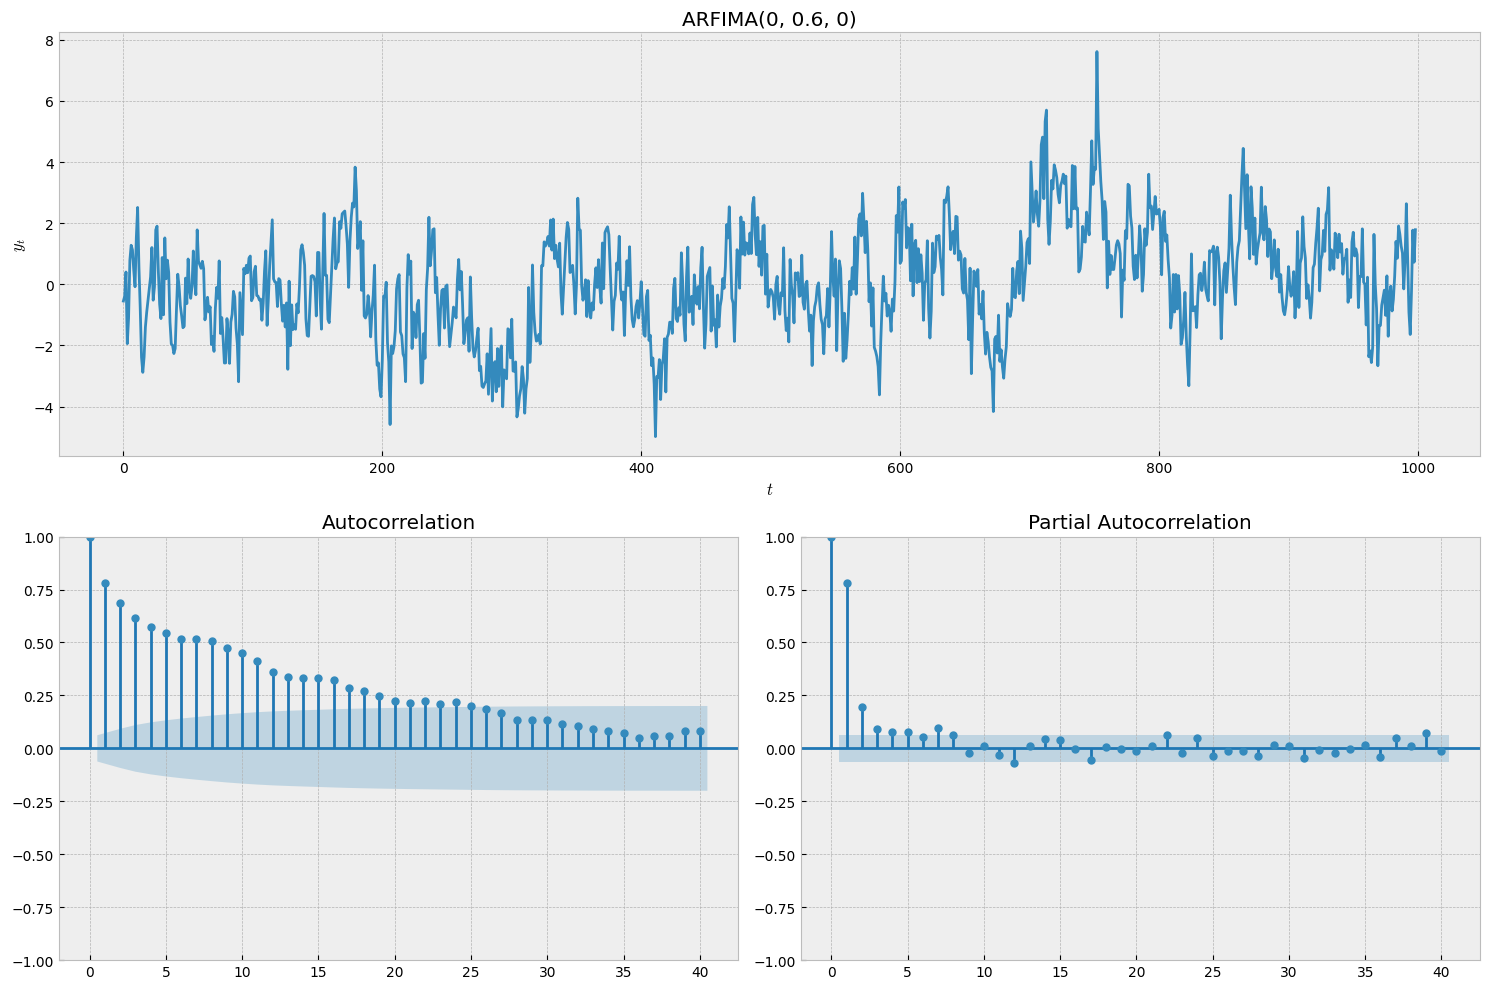

In [8]:
tsplot(model_arfima, lags = 40, title = 'ARFIMA(0, 0.6, 0)')

En la gráfica anterior puede observarse la persistencia de la correlación entre los retardos de la serie. No decrecen exponencialmente como ocurriría en un modelo ARMA.

Aplicamos los test ADF y KPSS para analizar la estacionariedad de la serie.

In [9]:
adfuller(model_arfima)[0:2]

(-5.038337489277755, 1.8625584643653296e-05)

In [10]:
kpss(model_arfima)[0:2]

(1.2161957880666132, 0.01)

## Gráficos

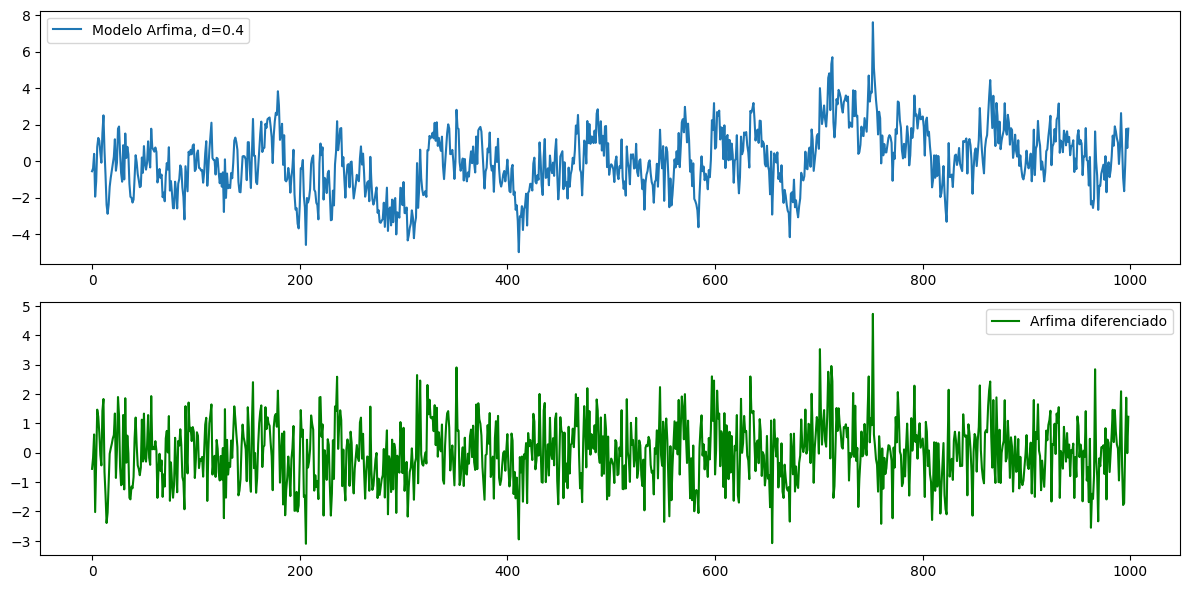

In [11]:
arfima_diff = __frac_diff(model_arfima, 0.4)
fig = plt.figure(figsize = (12,6))
layout = (2,1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = plt.subplot2grid(layout, (1, 0))
ax1.plot(model_arfima,  label = 'Modelo Arfima, d=0.4')
ax1.legend(loc = 'upper left')
ax2.plot(arfima_diff, label = 'Arfima diferenciado', color = 'green')
ax2.legend()
plt.tight_layout()
plt.show()

## Serie financiera

Consideraremos las diferenciaciones de orden d de la serie de datos de AAPL, y elegimos como mejor orden de diferenciación al primero que rechaza el test ADF con un p-valor menor a $0.005$.
Aplicamos la diferenciación de orden d con la función __frac_diff(x, d) del módulo arfima.

In [12]:
aapl_diff = __frac_diff(data['Adj Close'].dropna().values, 0.6)
for i in range(10):
    aapl_diff = __frac_diff(data['Adj Close'].dropna().values, i/10)
    pvalue = adfuller(aapl_diff)
    print('d=',i/10, adfuller(aapl_diff)[1])
    if pvalue[1] < 0.005:
        d = i/10
        break


d= 0.0 0.9933527012638801
d= 0.1 0.9621243055014049
d= 0.2 0.8522822716385364
d= 0.3 0.4803238966131036
d= 0.4 0.056157114480474266
d= 0.5 8.0119649907321e-05


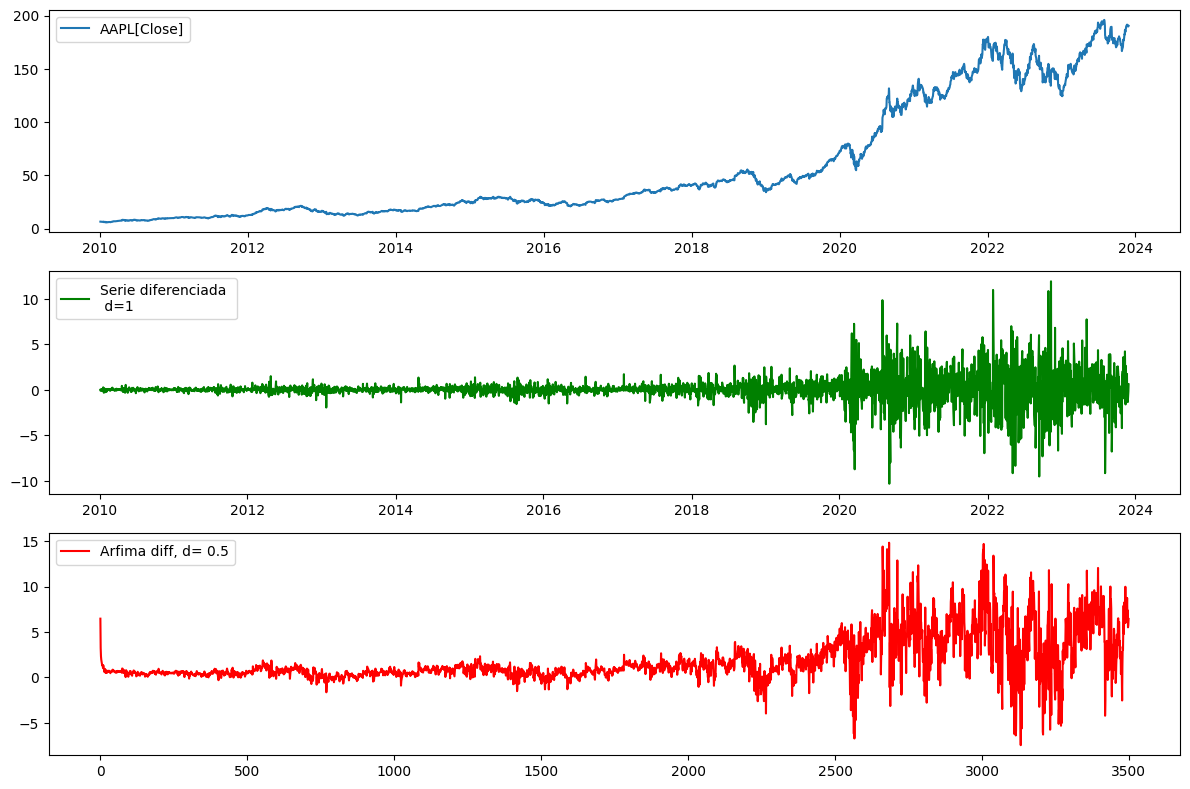

In [13]:
fig = plt.figure(figsize = (12,8))
layout = (3,1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = plt.subplot2grid(layout, (1, 0))
ax3 = plt.subplot2grid(layout, (2, 0))
ax1.plot(data['Adj Close'],  label = 'AAPL[Close]')
ax1.legend()
ax2.plot(data['Adj Close'].diff(), label = 'Serie diferenciada \n d=1 ', color = 'green')
ax2.legend()
ax3.plot(aapl_diff,  label = f'Arfima diff, d= {d}', color = 'red'  )

ax3.legend(loc = 'upper left')
plt.tight_layout()
plt.show()